# Precision of the algorithme on detecting objects from classes

**Plan**

* Look at most common objects 
* Make corpuses with 50 images for the 3 more importante categories
* Analyse precision (TruePositives / TruePositives + FalsePositives)


In [16]:
import cv2
import os, shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import json
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class_id = range(0,81)
class_dict = dict(zip(class_id, class_names))
df_class = pd.DataFrame.from_dict(class_dict, orient ='index', columns=['Class'])
df_class.reset_index(inplace=True)
df_class = df_class.rename(columns = {'index':'ID'})
class_dict

{0: 'BG',
 1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 25: 'backpack',
 26: 'umbrella',
 27: 'handbag',
 28: 'tie',
 29: 'suitcase',
 30: 'frisbee',
 31: 'skis',
 32: 'snowboard',
 33: 'sports ball',
 34: 'kite',
 35: 'baseball bat',
 36: 'baseball glove',
 37: 'skateboard',
 38: 'surfboard',
 39: 'tennis racket',
 40: 'bottle',
 41: 'wine glass',
 42: 'cup',
 43: 'fork',
 44: 'knife',
 45: 'spoon',
 46: 'bowl',
 47: 'banana',
 48: 'apple',
 49: 'sandwich',
 50: 'orange',
 51: 'broccoli',
 52: 'carrot',
 53: 'hot dog',
 54: 'pizza',
 55: 'donut',
 56: 'cake',
 57: 'chair',
 58: 'couch',
 59: 'potted plant',
 60: 'bed',
 61: 'dining table',
 62: 'toilet',
 63: 'tv',
 64: 'laptop'

**Look at most common classe detected by the Mask-RCNN**

As we are looking at people fisrt, then we have to look at objects linked to people in one image. For both corpus, art and esoterisme

In [3]:
#Get all files with a person

pE =  ' '
pers_filesE = []
for root, dirs, files in os.walk(pE):
    for f in tqdm(files):
        if f.endswith('1.json'):
            data = json.load(open(root+'/' + os.path.splitext(f)[0] +'.json', 'r'))
            pers_filesE.append(data['image_id'])

print(f'Number of files containing at least one body : {len(pers_filesE)}')

100%|██████████| 22386/22386 [00:16<00:00, 1319.96it/s]

Number of files containing at least one body : 3364


In [4]:
#Get all files with a person

pA =  ' '
pers_filesA = []
for r, d, fi in os.walk(pA):
    for fl in tqdm(fi):
        if fl.endswith('1.json'):
            data = json.load(open(r+'/' + os.path.splitext(fl)[0] +'.json', 'r'))
            pers_filesA.append(data['image_id'])

print(f'Number of files containing at least one body : {len(pers_filesA)}')

100%|██████████| 45388/45388 [00:29<00:00, 1550.11it/s]

Number of files containing at least one body : 7275


In [5]:
#Get all objects linked to a body in an image

obj_filesE = []
ext = ['1.json', '1.jpeg']
for root, dirs, files in os.walk(pE):
    for f in tqdm(files):
        if not f.endswith(tuple(ext)):
            if f.startswith(tuple(pers_filesE)):
                obj_filesE.append(f)
                
print(len(obj_filesE))

100%|██████████| 22386/22386 [00:01<00:00, 17604.88it/s]

10472


In [6]:
#Get all objects linked to a body in an image

obj_filesA = []
ext = ['1.json', '1.jpeg']
for r, d, fi in os.walk(pA):
    for fl in tqdm(fi):
        if not fl.endswith(tuple(ext)):
            if fl.startswith(tuple(pers_filesA)):
                obj_filesA.append(fl)
                
print(len(obj_filesA))

100%|██████████| 45388/45388 [00:05<00:00, 7822.36it/s] 

21751


In [7]:
ff=[]
for f in obj_filesE:
    ff.append(f[-6:-4])
    for i, v in enumerate(ff):
        if v.startswith('_'):
            ff[i] = v.replace(v, v[1])
        if v.endswith('.'):
            ff[i] = v.replace(v, v[0])

In [8]:
fs=[]
for f in obj_filesA:
    fs.append(f[-6:-4])
    for i, v in enumerate(fs):
        if v.startswith('_'):
            fs[i] = v.replace(v, v[1])
        if v.endswith('.'):
            fs[i] = v.replace(v, v[0])

In [9]:
#Count classes per corpus

a = Counter(ff)
df_count = pd.DataFrame.from_dict(a, orient ='index', columns=['Count Esoterisme'])
df_count.reset_index(inplace=True)
df_count = df_count.rename(columns = {'index':'ID'})
df_count = df_count.astype('int64')
df_count.sort_values(by='Count Esoterisme', ascending=False)

,ID,Count Esoterisme
0,1,2864
19,6,598
2,7,503
13,8,501
6,0,437
...,...,...
73,13,3
49,22,3
14,23,2
76,32,2


In [10]:
#Count classes per corpus

aa = Counter(fs)
df_countA = pd.DataFrame.from_dict(aa, orient ='index', columns=['Count Art'])
df_countA.reset_index(inplace=True)
df_countA = df_countA.rename(columns = {'index':'ID'})
df_countA = df_countA.astype('int64')
df_countA.sort_values(by='Count Art', ascending=False)

,ID,Count Art
0,1,6092
9,6,1092
4,7,1087
2,8,948
6,9,876
...,...,...
74,22,9
80,53,8
73,79,3
78,69,3


In [13]:
#Merge

dff = pd.merge(df_class, df_count, on=['ID','ID'])
df = pd.merge(dff, df_countA, on=['ID','ID'])

#Add percentage of files with a class for all the images

df['Esoterisme (%)'] = round((df_count['Count Esoterisme'] / len(obj_filesE))*100, 2)
df['Art (%)'] = round((df_countA['Count Art'] / len(obj_filesA))*100, 2)

df = df[['Class', 'Esoterisme (%)', 'Art (%)']]

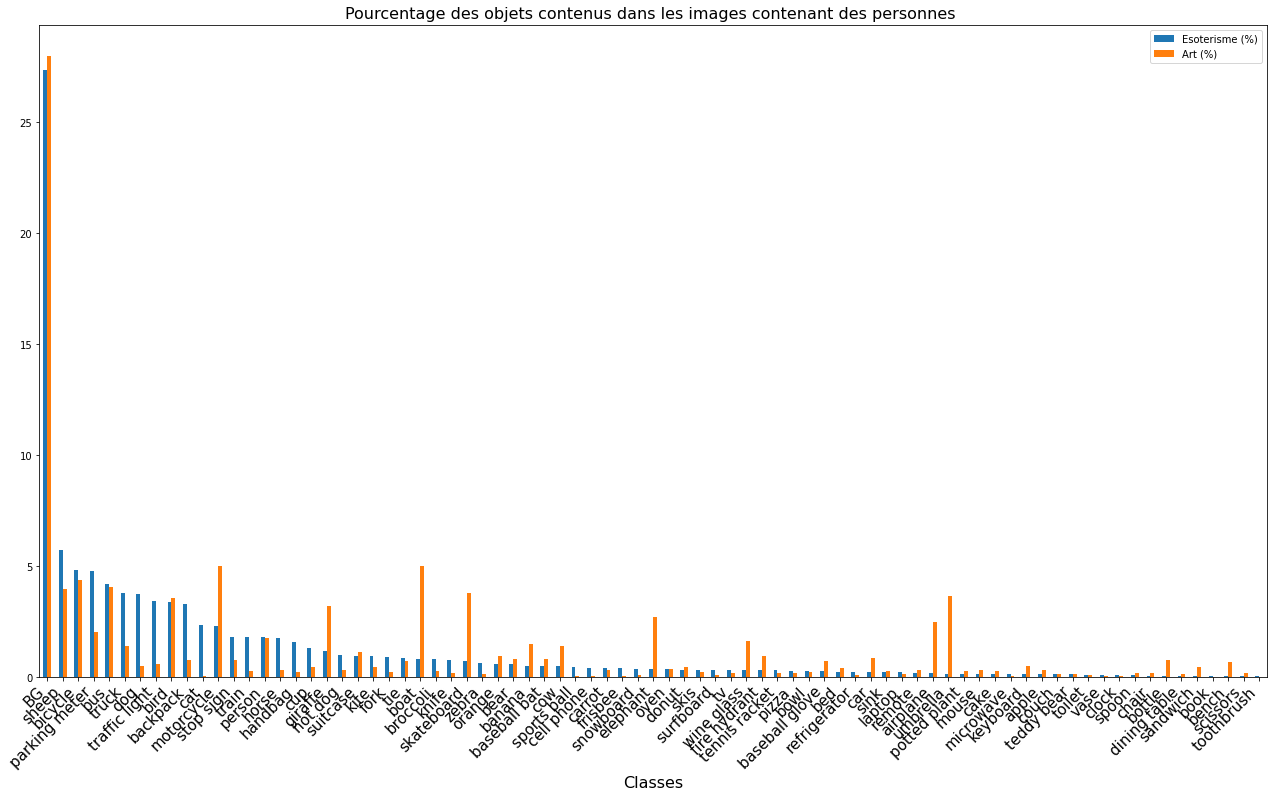

In [38]:
df.sort_values(['Esoterisme (%)', 'Art (%)'],ascending=False, inplace=True)
ax = df.set_index("Class").plot(kind = "bar", figsize=(22,12))
ax.set_xlabel("Classes", fontsize=16)
plt.title("Pourcentage des objets contenus dans les images contenant des personnes ", fontsize=16)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize=15)
#plt.savefig('object_people.svg')

After BG (background), who's a bit large for a class, the most common classes seems to be:

* Sheep (eso)
* Motorcycle (art)
* Boat (art)
* Bicycle (art + eso)
* Bus (art + eso)

In [21]:
class_dict

{0: 'BG',
 1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 25: 'backpack',
 26: 'umbrella',
 27: 'handbag',
 28: 'tie',
 29: 'suitcase',
 30: 'frisbee',
 31: 'skis',
 32: 'snowboard',
 33: 'sports ball',
 34: 'kite',
 35: 'baseball bat',
 36: 'baseball glove',
 37: 'skateboard',
 38: 'surfboard',
 39: 'tennis racket',
 40: 'bottle',
 41: 'wine glass',
 42: 'cup',
 43: 'fork',
 44: 'knife',
 45: 'spoon',
 46: 'bowl',
 47: 'banana',
 48: 'apple',
 49: 'sandwich',
 50: 'orange',
 51: 'broccoli',
 52: 'carrot',
 53: 'hot dog',
 54: 'pizza',
 55: 'donut',
 56: 'cake',
 57: 'chair',
 58: 'couch',
 59: 'potted plant',
 60: 'bed',
 61: 'dining table',
 62: 'toilet',
 63: 'tv',
 64: 'laptop'

**Create folder with each one of theses**

In [19]:
def Request(path_in: str, path_out: str, classID:int, class_dict):
    
    if not os.path.isdir(path_out):
        os.mkdir(path_out)

    c = classID
    ext = ['.jpg', '.jpeg', '.json', '.png']
    len_folder = []
    for root, dirs, files in os.walk(path_in):
        for f in tqdm(files):
            ff, fj = os.path.splitext(f)
            if fj.endswith(tuple(ext)):
                if ff.endswith('_' + str(c)):
                    filepath = os.path.join(root, f)
                    path_save = os.path.join(path_out + '/' +f)
                    path_from = os.path.join(root + '/' + f)
                    os.stat(path_out).st_mode
                    len_folder.append(f)
                    shutil.copy(path_from, path_save)
            else:
                continue
                
    for key,value in class_dict.items():
        if key == int(c):
            v = value

    print(f'Done !\n{len(len_folder)} images for class :' + str(v))

In [26]:
Request(path_in= input('Enter path in : '), path_out=input('Enter path out : '), classID=input('Enter Class ID : '), class_dict=class_dict)

Enter path in :  ../M_venus/corpus_esoterism_mask
Enter path out :  ../M_venus/corpus_esoterism_maskC6
Enter Class ID :  6


100%|██████████| 22386/22386 [00:00<00:00, 120099.68it/s]

Done !
12 images for class :bus


**Compute precision**

In [28]:
#Sheep (19) - 19/19 images 

tp = 5
fp = 14

psheep = round((tp /(tp + fp))*100, 2)
print(f"Precision for sheep is at {psheep} %")

Precision for sheep is at 26.32 %


In [29]:
#Motorcycle (4) - 50/72 images 

tp = 14
fp = 36

pmot = round((tp /(tp + fp))*100, 2)
print(f"Precision for motorcycle is at {pmot} %")

Precision for motorcycle is at 28.0 %


In [33]:
#Boat (9) - 50/268 images 

tp = 2
fp = 48

pboat = round((tp /(tp + fp))*100, 2)
print(f"Precision for boat is at {pboat} %")

Precision for boat is at 4.0 %


In [34]:
#Bicycle (2) - 50/74 images 

tp = 12
fp = 38

p = round((tp /(tp + fp))*100, 2)
print(f"Precision for bicycle is at {p} %")

Precision for bicycle is at 24.0 %


In [35]:
#Bus (6) - 6/6 images 

tp = 0
fp = 6

p = round((tp /(tp + fp))*100, 2)
print(f"Precision for bus is at {p} %")

Precision for bus is at 0.0 %
